In [2]:
# импортируем необходимые библиотеки для анализа данных и построении графиков, а также для проведения статистического теста
import numpy as np
import pandas as pd
import pandahouse
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# зададим параметры для будущих графиков
sns.set(rc={'figure.figsize':(16,12)}, style="whitegrid", font='sans-serif')

## Задача:
В период с 2023-12-29 по 2024-01-04 включительно, в приложении, а именно в ленте новостей, проводился A/B тест, целью которого являлась проверка на тестируемой группе пользователей нового алгоритма рекомендательной системы. Для нашего теста будем проводить сравнение на стандартной метрике CTR количество лайков / количество просмотров, так как на основании неё можно увидеть явную заинтересованость в действии - лайки.

* exp_group = 1 Контрольная группа (рекомендации без изменении)
* exp_group = 2 Тестируемая группа (новая система рекомендации)

In [3]:
# при помощи библиотеки Pandahouse подключимся к базе данных, из которой отберём пользователей, количество их лайков, просмотров, а также сразу посчитаем CTR.

connection = {                                            # словарик с данными для подключения к базе данных
    'host': '**********', # указываем хост базы данных
    'password': '*********', # пароль к базе данных
    'user': '**********', # имя пользователя
    'database': '******' # раздел базы данных
}

# SQL запрос к базе данных
q ="""        
select user_id, 
       exp_group, 
       sum(action='like') as likes, 
       sum(action='view') as views, 
       likes/views as ctr
from simulator_20240120.feed_actions
where toDate(time) between '2023-12-29' and '2024-01-04' and exp_group in (1, 2)
group by user_id, exp_group
"""

df_ab = pandahouse.read_clickhouse(q, connection=connection)

df_ab.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,18392,1,7,32,0.218750
4,26295,1,39,141,0.276596


In [4]:
# количество строк и столбцов
df_ab.shape

(19897, 5)

In [5]:
# количество пропущенных значений
df_ab.isna().sum()

user_id      0
exp_group    0
likes        0
views        0
ctr          0
dtype: int64

In [5]:
# посмотрим количество пользователей в рассматриваемых группах
df_ab.groupby('exp_group', as_index=False)['user_id'].nunique()

,exp_group,user_id
0,1,10020
1,2,9877


## Проведение A/A теста:
Для проведения A/B теста необходимо удостовериться, что наши группы примерно одинаковые и что показатели в них сами по себе до введения новой рекомендательной системы не различаются, для этого проведём A/A тест.

* Предварительно сразу можно утверждать, что количество пользователей в группах примерно равное
* А/A тест проводился в период с 2023-12-22 г. по 2023-12-28 г.

In [7]:
# отберём пользователей A/A теста из базы данных
q ="""
select user_id,
       exp_group,
       sum(action='like') as likes, 
       sum(action='view') as views, 
       likes/views as ctr
from simulator_20240120.feed_actions
where toDate(time) between '2023-12-22' and '2023-12-28' and exp_group in (1, 2)
group by user_id, exp_group
"""

df_aa = pandahouse.read_clickhouse(q, connection=connection)

df_aa.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,10,34,0.294118
1,18392,1,13,56,0.232143
2,131473,2,19,98,0.193878
3,23985,2,12,44,0.272727
4,24523,2,2,10,0.200000


In [8]:
# количество пропущенных значений
df_aa.isna().sum()

user_id      0
exp_group    0
likes        0
views        0
ctr          0
dtype: int64

In [17]:
# посмотрим количество пользователей в рассматриваемых группах
df_aa.groupby('exp_group', as_index=False)['user_id'].nunique()

,exp_group,user_id
0,1,8491
1,2,8362


Визуально посмотрим на распределение метрики CTR в группах

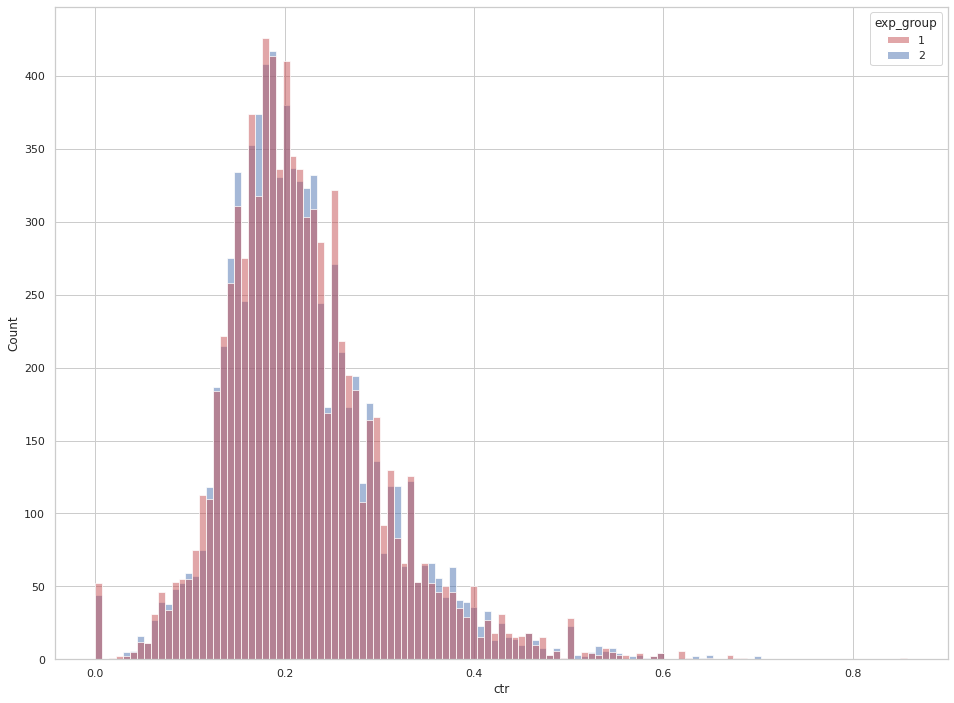

In [13]:
groups_aa = sns.histplot(data = df_aa, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

"На глаз" группы примерно равны, но необходимо подтвердить это при помощи статистических методов, учитывая, что наше распределение **нормальное**, воспользуемся **t-критерием Стьюдента, значение альфы = 0.05**

* нулевая гипотеза заключается в том, что между группами нет статистически значимых отличий
* альтернативная гипотеза, что между группами есть статистически значимые отличия

In [16]:
# t-критерий Стьюдента
stats.ttest_ind(df_aa[df_aa.exp_group == 1].ctr,
                df_aa[df_aa.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.5694920635629134, pvalue=0.5690298477939706)

В нашем случае P-value = 0.569, что намного больше значения альфы, в соответствии с этим **основании утверждать, что группы разные у нас нет.**

## Проведение A/B теста:
Целью нашей работы является проверка в тестируемой группе новой рекомендательной системы, которая по предположению должна увеличить CTR, поэтому для начала посмотрим на графики распределения CTR по нашим группам.

<AxesSubplot:title={'center':'График CTR группа №1'}, ylabel='Count'>

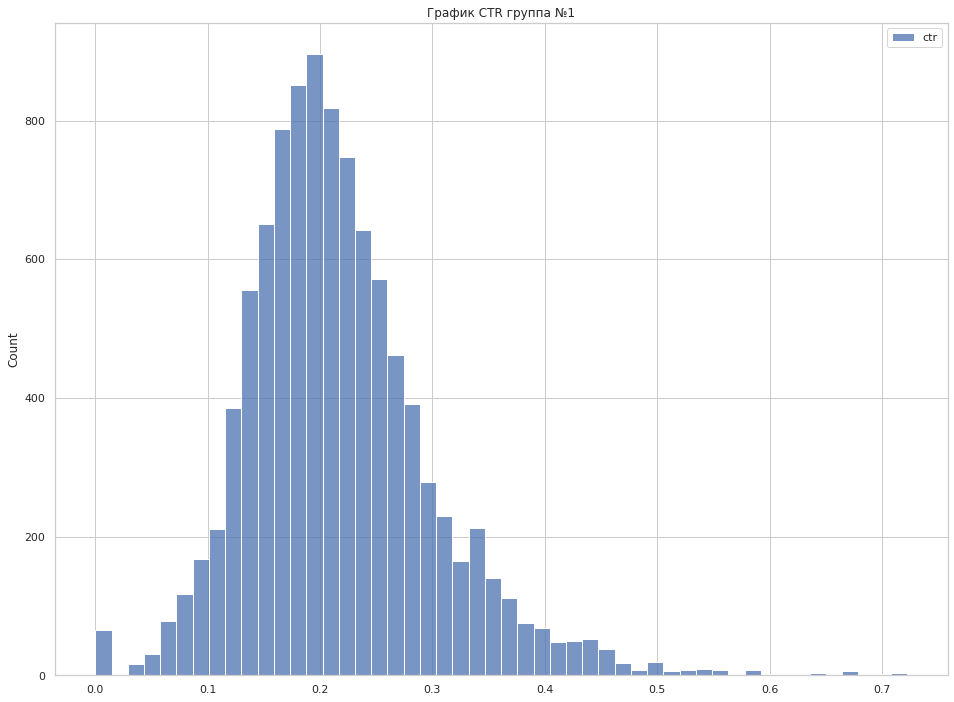

In [19]:
# распределение CTR группы №1, визуально похоже на нормальное, большинство значений сосредоточены в промежутке от 0.1 до 0.3
plt.title('График CTR группа №1')
sns.histplot(df_ab.query('exp_group == 1')[['ctr']], bins=50)

In [18]:
# статистики CTR группы №1
df_ab.query('exp_group == 1')[['ctr']].describe()

,ctr
count,10020.000000
mean,0.216774
std,0.082969
min,0.000000
25%,0.163636
50%,0.205882
75%,0.257870
max,0.722222


<AxesSubplot:title={'center':'График CTR группа №2'}, ylabel='Count'>

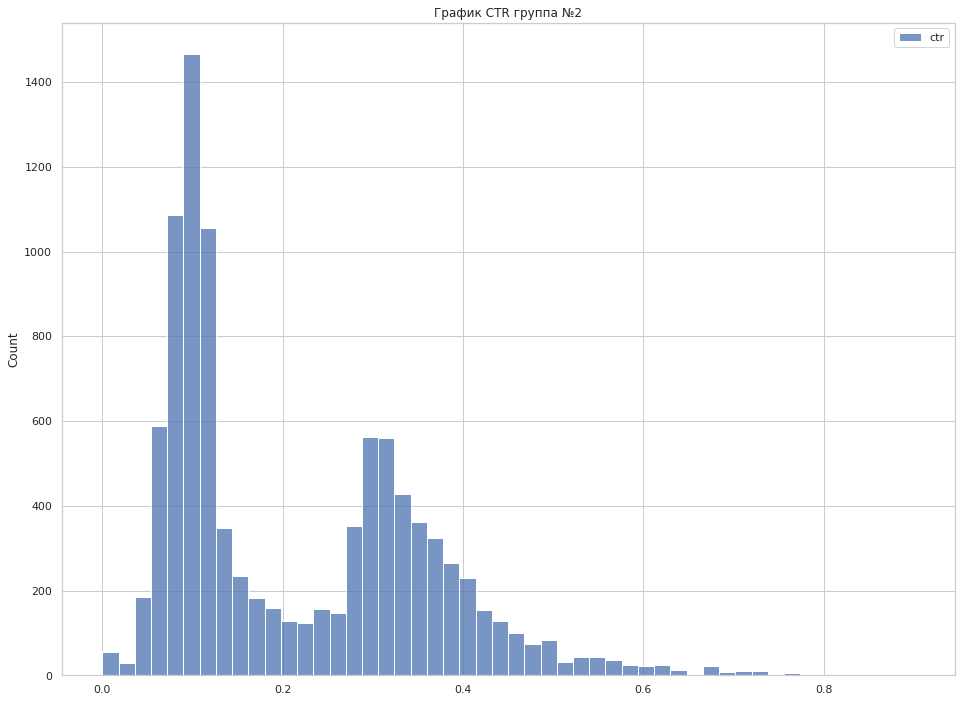

In [20]:
# распределение CTR группы №2, визуально отличается от нормального распределения, имеет 2 "горба"
plt.title('График CTR группа №2')
sns.histplot(df_ab.query('exp_group == 2')[['ctr']], bins=50)

In [21]:
# статистики CTR группы #2
df_ab.query('exp_group == 2')[['ctr']].describe()

,ctr
count,9877.000000
mean,0.216102
std,0.142870
min,0.000000
25%,0.096774
50%,0.153285
75%,0.323529
max,0.900000


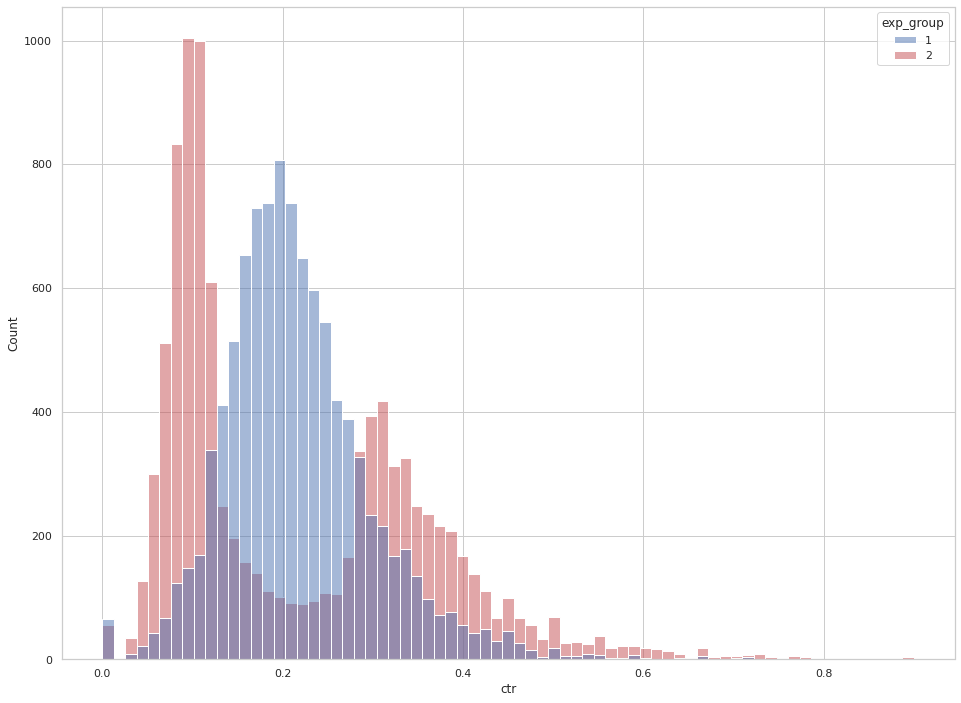

In [23]:
# общее распределение между группами
groups = sns.histplot(data = df_ab, 
                      x = 'ctr', 
                      hue = 'exp_group', 
                      alpha = 0.5, 
                      palette=['b', 'r'], 
                      kde=False)

Для проверки новой системы рекомендации в ленте новостей проведём A/B тест разными статистическими методами, при помощи которых проверим, увеличится ли показатель CTR во второй группе, будет он меньше или на уровне группы №1, учитывая, что CTR в группе 2 визуально распределён не 'нормально', в первую очередь для A/B теста будем использовать метод Пуассоновский бутстреп, при помощи которого определим глобальный CTR по подгруппам.

In [11]:
# функция статистического критерия Пуассоновский бутстреп, в функцию будем подавать массивы лайков и просмотров

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [9]:
# создадим массивы со значениями лайков и просмотров в разбивке на 2 группы

likes1 = df_ab[df_ab.exp_group == 1].likes.to_numpy()
views1 = df_ab[df_ab.exp_group == 1].views.to_numpy()
likes2 = df_ab[df_ab.exp_group == 2].likes.to_numpy()
views2 = df_ab[df_ab.exp_group == 2].views.to_numpy()

<AxesSubplot:ylabel='Count'>

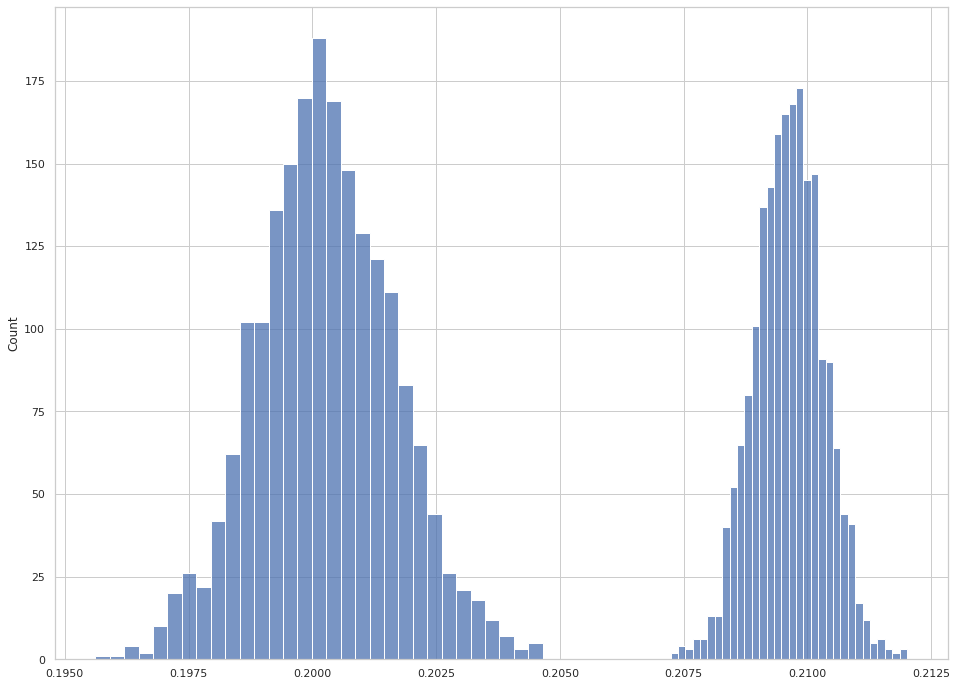

In [12]:
# посмотрим на график распределения глобального CTR в группах
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

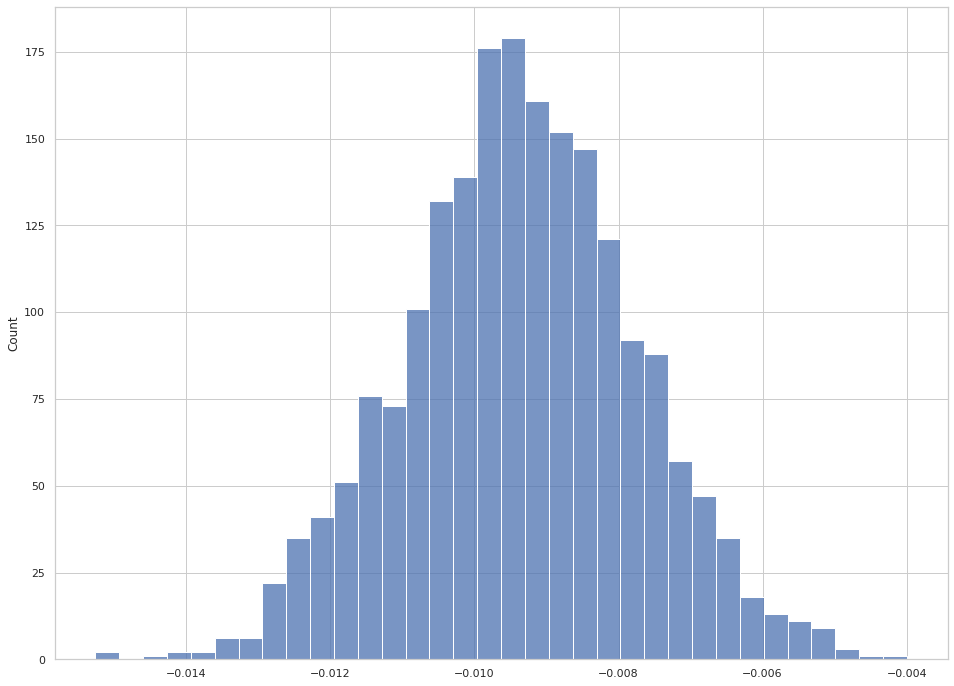

In [27]:
#построим график разницы распределений CTR между группами 1 и 2.

sns.histplot(ctr2 - ctr1)

## Промежуточные итоги:
при помощи Пуассоновского бутстрэпа мы провели A/B тестирование между группами 1 (контрольной) и 2 (тестовой), в ходе которого установили, что графики распределения глобального CTR между группами не пересекается, а разница между таргетной группой и основной отрицательная, на основании чего можно сделать вывод, что при новой рекомендательной системе глобальный CTR станет меньше, в данном случае "раскатывать" новую систему рекомендации на всех пользователей не имеет смысла.

## Проведём A/B тест при помощи статистических критерий t-test Стьюдента, а также тест Манна-Уитни. P-value будем сравнивать с альфой = 0.05, также будем опираться на 2 гипотезы:
1. Средний CTR в группах не имеет различии.
2. Средний CTR в группах имеет статистически значимые различия.





In [27]:
df_ab.head()

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,18392,1,7,32,0.218750
4,26295,1,39,141,0.276596


In [15]:
stats.ttest_ind(df_ab[df_ab.exp_group == 1].ctr, 
             df_ab[df_ab.exp_group == 2].ctr, 
             equal_var=False)[1]

0.685373331140751

In [16]:
# проведем A/B тест при помощи метода Манна-Уитни
print(stats.mannwhitneyu(df_ab[df_ab.exp_group == 1].ctr,
                df_ab[df_ab.exp_group == 2].ctr))

print('Отличие не прокрасилось')

A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df_ab[df_ab.exp_group == 1].ctr.sample().values[0] > df_ab[df_ab.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)
Отличие не прокрасилось
В 55.35 % случаев A > B. Должно получиться около 50%


## Промежуточные итоги: 
при проведении T-testa мы получили P-value = 0.685, что намного больше значения альфа = 0.05, соответственно в данном случае отклонить 0 гипотезу мы не можем, также при проведении теста статистическим критерием Манна-Уитни мы получили, что CTR в группе №1 в 55.4% больше показателей CTR в группе №2.

## Проведём A/B тест поверх бакетного преобразования:
* поделим пользователей на бакеты, так как в наших группах примерно по 10 000 пользователей, будем использовать 50 бакетов, в каждом из которых будет примерно 200 пользователей.
* для подсчёта статистики в каждом бакете будем использовать 90% квантиль CTR, а также общий CTR в каждом бакете.
* посмотрим на бакетное распределение по эксперементальным группам.
* будем проводить A/B тест.

In [5]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20240120.feed_actions
    where toDate(time) between '2023-12-29' and '2024-01-04' and exp_group in (1, 2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_ab_bucket = pandahouse.read_clickhouse(q, connection=connection)
df_ab_bucket.head()

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.200592,0.305556
1,2,0,0.196510,0.385321
2,1,1,0.208799,0.311111
3,2,1,0.210375,0.485714
4,1,2,0.204632,0.314286


## Посмотрим на распределения среднего побакетного CTR

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

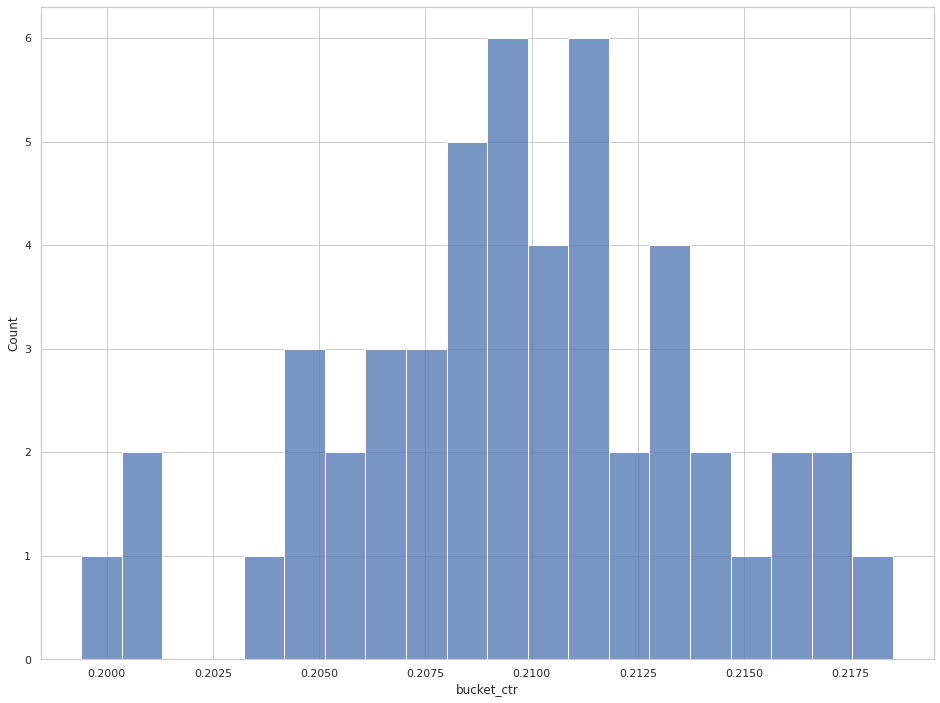

In [6]:
# группа №1
sns.histplot(df_ab_bucket[df_ab_bucket.exp_group == 1].bucket_ctr, bins=20)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

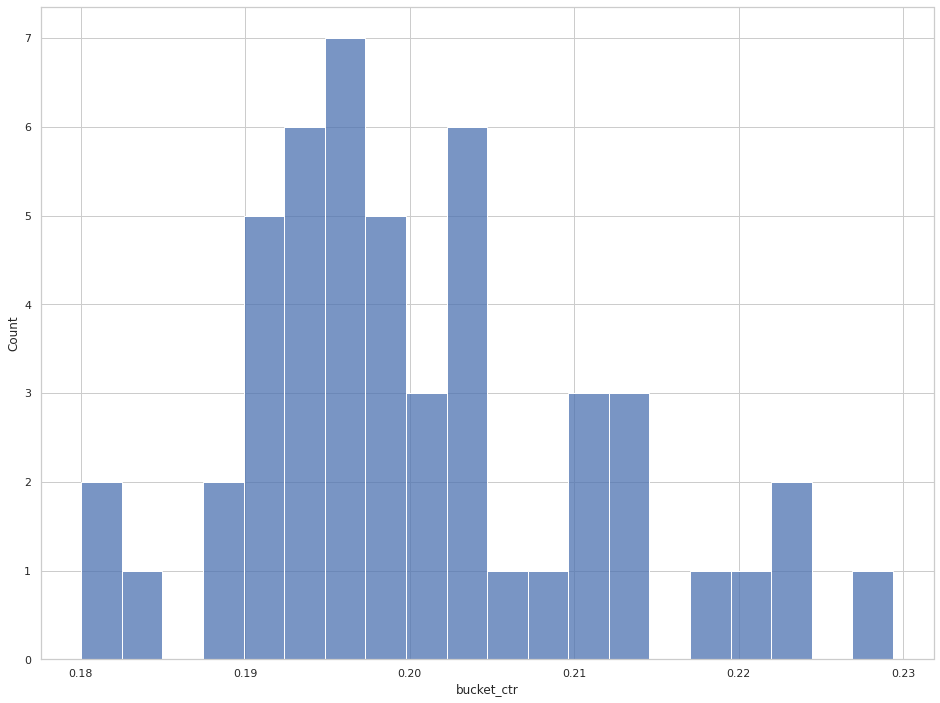

In [20]:
# группа №2
sns.histplot(df_ab_bucket[df_ab_bucket.exp_group == 2].bucket_ctr, bins=20)

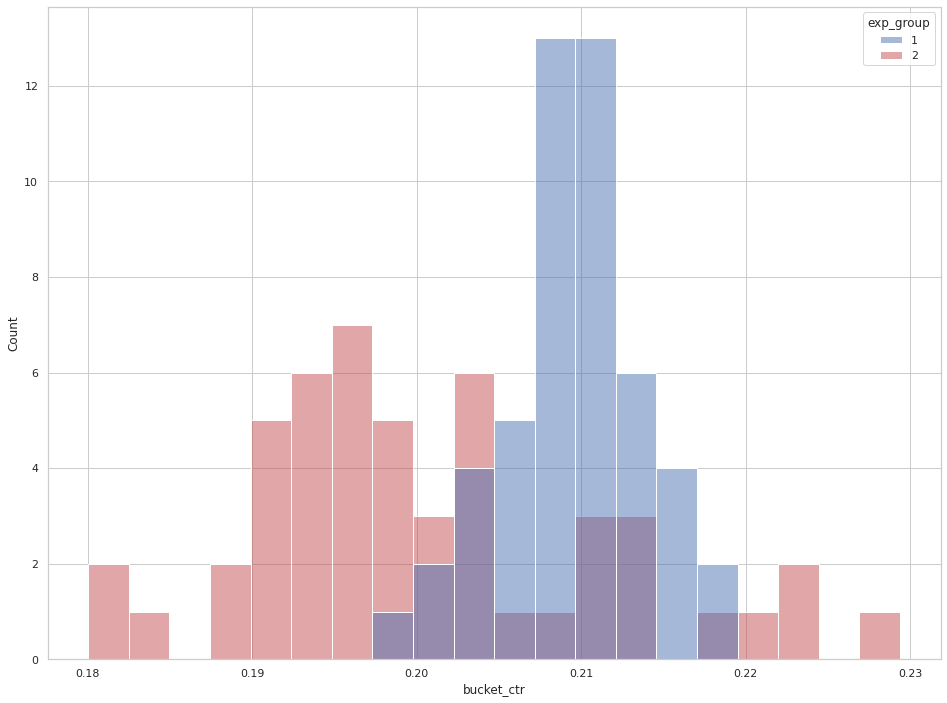

In [15]:
# общее распределение между группами
groups = sns.histplot(data = df_ab_bucket, 
                      x = 'bucket_ctr', 
                      hue = 'exp_group', 
                      alpha = 0.5, 
                      palette=['b', 'r'], 
                      kde=False,
                      bins=20)

Посмотрим на распределение 90% квантиля CTR по бакетам

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

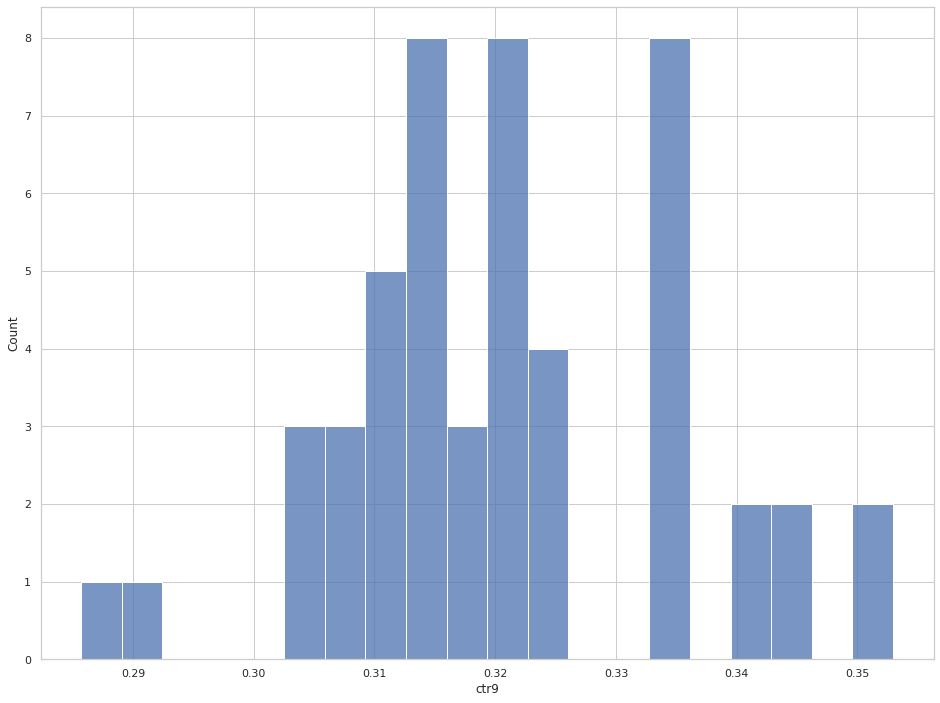

In [8]:
# группа №1
sns.histplot(df_ab_bucket[df_ab_bucket.exp_group == 1].ctr9, bins=20)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

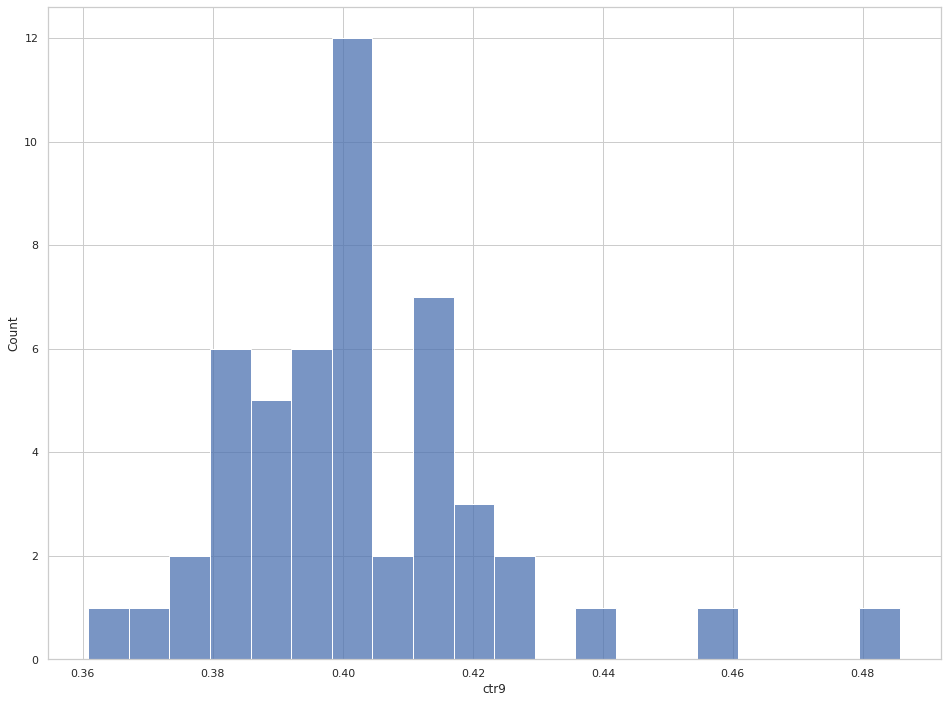

In [9]:
# группа №2
sns.histplot(df_ab_bucket[df_ab_bucket.exp_group == 2].ctr9, bins=20)

График группы №1 схож с нормальным распределением, график №2 имеет скос в правую сторону, при этом предельных выбросов на графике не наблюдается, а на графиках 90% квантиля наоборот, в группе номер 2№ график более близок к нормальному распределению чем в группе №1.

Поверх бакетного преобразования проведём стандартный t-test

In [11]:
#t-тест

stats.ttest_ind(df_ab_bucket[df_ab_bucket.exp_group == 1].bucket_ctr, 
                   df_ab_bucket[df_ab_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

In [12]:
stats.ttest_ind(df_ab_bucket[df_ab_bucket.exp_group == 1].ctr9, 
                   df_ab_bucket[df_ab_bucket.exp_group == 2].ctr9, 
                   equal_var = False)

Ttest_indResult(statistic=-22.821214612754606, pvalue=4.17295352116894e-38)

## Выводы: 
* после проведения всех тестов можно сделать вывод, что между группами 1 и 2 имеются различия в разнице CTR, как глобального так и пользовательского, это подтверждают проведенные ранее тесты.
* основной задачей проведения A/B тестирования было подтверждение или опровержение гипотезы которая заключалась в том, что новый алгоритм рекомендации во 2-й группе приведет к увеличению CTR, на основании проведенных тестов можно утверждать, что новый алгоритм рекомендации в группе 2 не повышает CTR, а наоборот уменьшает его, в связи с чем, раскатывать новый алгоритм на пользователей не стоит.
* причинами снижения CTR в группе №2 могут являться не правильный отбор пользователей для тестирования, распределение CTR во второй группе не нормальное.